<a href="https://colab.research.google.com/github/nidanafila/NLP-Text-Classification/blob/main/NLP_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : Nida Nafila

E-mail : naifanida5858@gmail.com

In [11]:
#install data dari kaggle
!pip install -q kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

#download dataset
!kaggle datasets download -d hgultekin/bbcnewsarchive

!mkdir bbcnewsarchive
!unzip bbcnewsarchive.zip -d bbcnewsarchive
!ls bbcnewsarchive

Saving kaggle.json to kaggle (3).json
kaggle.json
bbcnewsarchive.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘bbcnewsarchive’: File exists
Archive:  bbcnewsarchive.zip
replace bbcnewsarchive/bbc-news-data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: bbcnewsarchive/bbc-news-data.csv  
bbc-news-data.csv


In [12]:
#import library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.preprocessing import text, sequence
import nltk
nltk.download('stopwords')
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The Dataset


In [14]:
df = pd.read_csv('bbcnewsarchive/bbc-news-data.csv', sep='\t' )
df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [17]:
df.shape

(2225, 4)

In [18]:
df.isnull().sum()

category    0
filename    0
title       0
content     0
dtype: int64

In [19]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   filename  2225 non-null   object
 2   title     2225 non-null   object
 3   content   2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB
None


In [20]:
df.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [21]:
df = df.drop(columns=['filename'])
df

,category,title,content
0,business,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...
2220,tech,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,Be careful how you code,A new European directive could put software w...
2223,tech,US cyber security chief resigns,The man making sure US computer networks are ...


<Axes: xlabel='count', ylabel='category'>

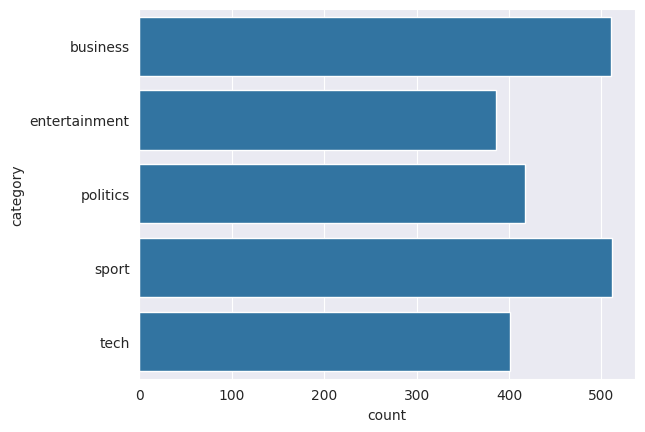

In [22]:
#visualisation based on category
sns.set_style("darkgrid")
sns.countplot(df.category)

In [23]:
df.title.count()

2225

In [24]:
df['text'] = df['title'] + " " + df['content']
df

,category,title,content,text
0,business,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,Ad sales boost Time Warner profit Quarterly p...
1,business,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,Dollar gains on Greenspan speech The dollar h...
2,business,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,Yukos unit buyer faces loan claim The owners ...
3,business,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,High fuel prices hit BA's profits British Air...
4,business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,Pernod takeover talk lifts Domecq Shares in U...
...,...,...,...,...
2220,tech,BT program to beat dialler scams,BT is introducing two initiatives to help bea...,BT program to beat dialler scams BT is introd...
2221,tech,Spam e-mails tempt net shoppers,Computer users across the world continue to i...,Spam e-mails tempt net shoppers Computer user...
2222,tech,Be careful how you code,A new European directive could put software w...,Be careful how you code A new European direct...
2223,tech,US cyber security chief resigns,The man making sure US computer networks are ...,US cyber security chief resigns The man makin...


Data Cleaning

In [28]:
stwd = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stwd.update(punctuation)

In [32]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_url(text):
    return re.sub(r'http\S+', '', text)

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stwd:
            final_text.append(i.strip())
    return " ".join(final_text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_url(text)
    text = remove_stopwords(text)
    return text

df['text'] = df['text'].apply(denoise_text)

In [33]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(news_data.text)
corpus[:10]

['Ad',
 'sales',
 'boost',
 'Time',
 'Warner',
 'profit',
 'Quarterly',
 'profits',
 'US',
 'media']

In [34]:
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'said': 4899,
 'Mr': 2979,
 'would': 2555,
 'also': 2098,
 'people': 1695,
 'said.': 1499,
 'could': 1494,
 'new': 1490,
 'one': 1376,
 'US': 1346}

<Axes: >

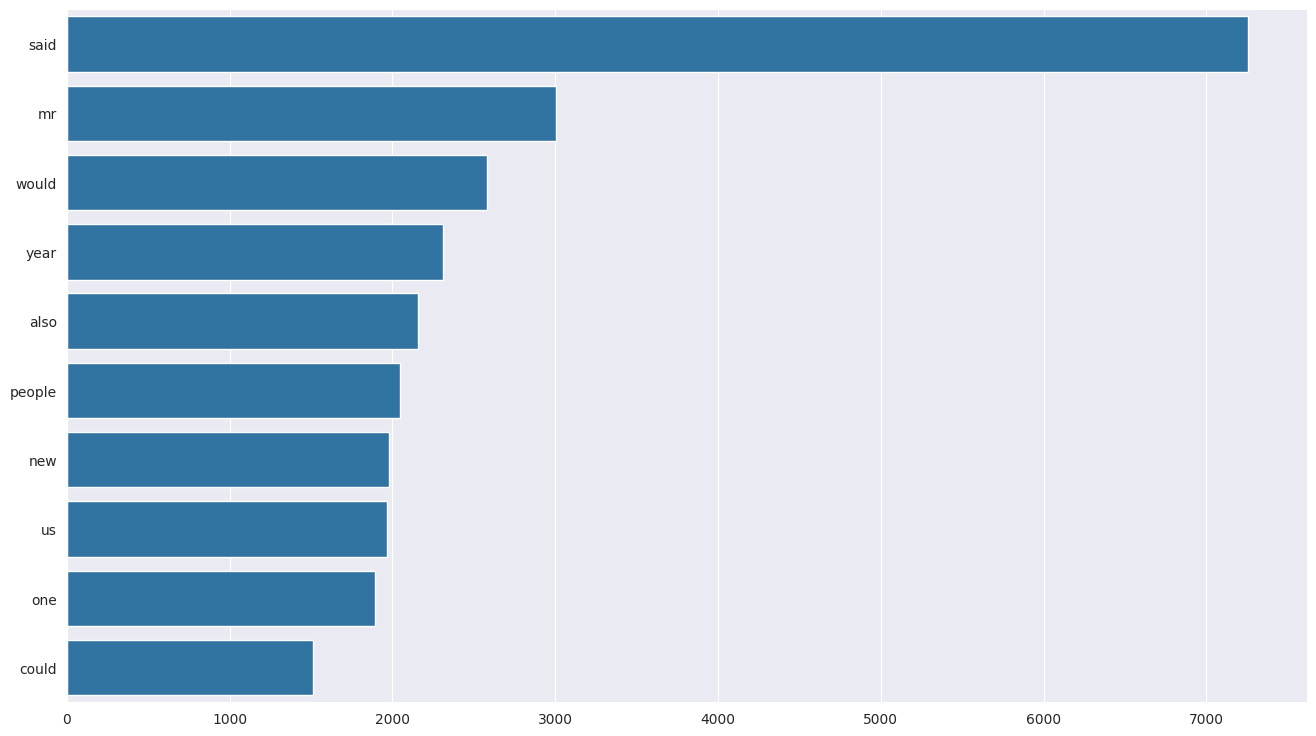

In [36]:
def get_top_text_ngrams(corpus, n, g):
    cv = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_words = cv.transform(corpus)
    sum_words = bag_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

plt.figure(figsize = (16,9))
most_common = get_top_text_ngrams(news_data.text,10,1)
most_common = dict(most_common)
sns.barplot(x=list(most_common.values()),y=list(most_common.keys()))

Split Data

In [37]:
category = pd.get_dummies(news_data.category)
new_cat = pd.concat([news_data, category], axis=1)
new_cat = new_cat.drop(columns='category')
new_cat.head(10)

,title,content,text,business,entertainment,politics,sport,tech
0,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,Ad sales boost Time Warner profit Quarterly pr...,1,0,0,0,0
1,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,Dollar gains Greenspan speech dollar hit highe...,1,0,0,0,0
2,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,Yukos unit buyer faces loan claim owners embat...,1,0,0,0,0
3,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,High fuel prices hit BA's profits British Airw...,1,0,0,0,0
4,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,Pernod takeover talk lifts Domecq Shares UK dr...,1,0,0,0,0
5,Japan narrowly escapes recession,Japan's economy teetered on the brink of a te...,Japan narrowly escapes recession Japan's econo...,1,0,0,0,0
6,Jobs growth still slow in the US,The US created fewer jobs than expected in Ja...,Jobs growth still slow US US created fewer job...,1,0,0,0,0
7,India calls for fair trade rules,"India, which attends the G7 meeting of seven ...","India calls fair trade rules India, attends G7...",1,0,0,0,0
8,Ethiopia's crop production up 24%,Ethiopia produced 14.27 million tonnes of cro...,Ethiopia's crop production 24% Ethiopia produc...,1,0,0,0,0
9,Court rejects $280bn tobacco case,A US government claim accusing the country's ...,Court rejects $280bn tobacco case US governmen...,1,0,0,0,0


In [42]:
news = new_cat['text'].values
label = new_cat[['business', 'entertainment', 'politics', 'sport', 'tech']].values
news

array(['Ad sales boost Time Warner profit Quarterly profits US media giant TimeWarner jumped 76% $1.13bn (£600m) three months December, $639m year-earlier. firm, one biggest investors Google, benefited sales high-speed internet connections higher advert sales. TimeWarner said fourth quarter sales rose 2% $11.1bn $10.9bn. profits buoyed one-off gains offset profit dip Warner Bros, less users AOL. Time Warner said Friday owns 8% search-engine Google. internet business, AOL, mixed fortunes. lost 464,000 subscribers fourth quarter profits lower preceding three quarters. However, company said AOL\'s underlying profit exceptional items rose 8% back stronger internet advertising revenues. hopes increase subscribers offering online service free TimeWarner internet customers try sign AOL\'s existing customers high-speed broadband. TimeWarner also restate 2000 2003 results following probe US Securities Exchange Commission (SEC), close concluding. Time Warner\'s fourth quarter profits slightly be

In [41]:
label

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]], dtype=uint8)

In [44]:
x_train,x_test,y_train,y_test = train_test_split(news, label,test_size = 0.2,shuffle=True)

Tokenizer

In [45]:
vocab_size = 10000
max_len = 200
trunc_type = "post"
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index

sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)
pad_train = pad_sequences(sequences_train, maxlen=max_len, truncating=trunc_type)
pad_test = pad_sequences(sequences_test, maxlen=max_len, truncating=trunc_type)

print(pad_test.shape)

(445, 200)


In [46]:
pad_train

array([[1738, 1141, 1985, ...,    4, 3084,  834],
       [  33, 1385,   26, ...,   26,   35, 3301],
       [ 148, 6101, 2280, ...,  814,  405,  289],
       ...,
       [   0,    0,    0, ...,   88,  766,  180],
       [   0,    0,    0, ..., 3730, 4471, 3796],
       [   0,    0,    0, ..., 8955, 7133,    1]], dtype=int32)

In [47]:
pad_test

array([[1888, 2392,  702, ..., 2673, 3109,  210],
       [   0,    0,    0, ...,    3,    1,    2],
       [   0,    0,    0, ...,    1, 2945, 1845],
       ...,
       [1276, 4597,   76, ...,   70,    7,    1],
       [  35,  267, 1513, ..., 5817, 3138,  179],
       [   0,    0,    0, ..., 5120, 2592,  671]], dtype=int32)

Pemodelan Sequential

In [53]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy',)
model.summary()

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.93 and logs.get('val_accuracy')>0.93):
      self.model.stop_training = True
      print("Akurasi terlampaui!!")
callbacks = myCallback()

num_epochs = 50
history = model.fit(pad_train, y_train, epochs=num_epochs,
                    validation_data=(pad_test, y_test), verbose=2, callbacks=[callbacks])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 64)           640000    
                                                                 
 lstm_4 (LSTM)               (None, 128)               98816     
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 5)                 645       
                                                                 
Total params: 755973 (2.88 MB)
Trainable params: 755973 (2.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
56/56 -

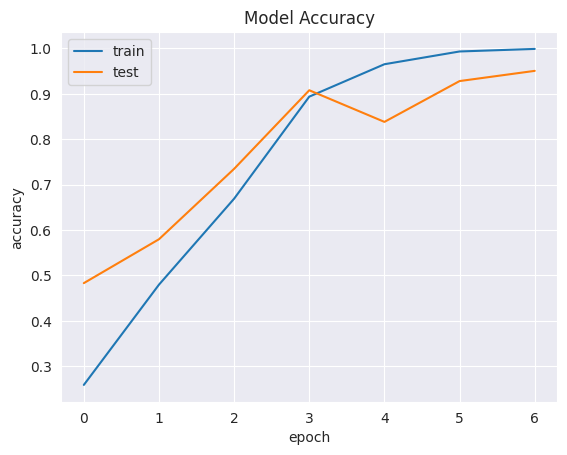

In [51]:
# plot of accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

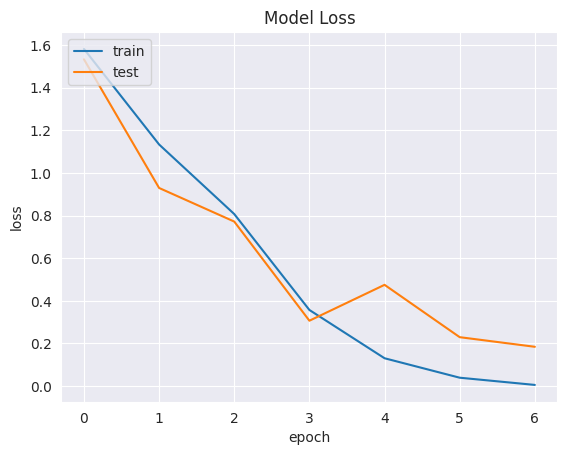

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()